# Full attack detection by Random Forest (CICID-IDS2017 dataset)

## Построение модели

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import pandas as pd
import time

#тренировочный набор
train_df = pd.read_csv('Preprocessed_train_data_selection.csv', low_memory=True)
#тестовый набор
test_df = pd.read_csv('Preprocessed_test_data_selection.csv', low_memory=True)


y_train, x_train = train_df["Label"], train_df.drop(columns=["Label"]).copy()

y_test, x_test = test_df["Label"], test_df.drop(columns=["Label"]).copy()

#На всякий случай запускаем проверку на соответствие признаков
miss_cols = set(x_train.columns) - set(x_test.columns)
extra_cols = set(x_test.columns) - set(x_train.columns)

if miss_cols or extra_cols:
    print(f"[!] Предупреждение: есть несоответствие в колонках между train и test")
    print(f"Отсутствуют в test: {missing_cols}")
    print(f"Лишние в test: {extra_cols}")
else:
    print("Данные успешно загружены, ошибок не возникло!")

Данные успешно загружены, ошибок не возникло!


### Перед тестированием модели приводим количество примеров к одинаковомучислу для каждого класса

In [5]:
"""Для того, чтобы протестировать точность модели по каждому классу,
    занижаем каличество примеров каждого класса,
    до количества примерова самого минимального класса
    в ТЕСТОВОМ наборе данных!!!
"""
# применение undersampling к тестовой выборке
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#занижаю классы тестового набора до количество примеров самого наименьшего (452)
rus = RandomUnderSampler(random_state=42)

#автоматическое преобразование всех классов к количеству самого маленького
# Работа только с тестовым примером!
x_test_balanced, y_test_balanced = rus.fit_resample(x_test, y_test)


print(Counter(y_test_balanced))

Counter({0: 452, 1: 452, 2: 452, 3: 452, 4: 452, 5: 452, 6: 452, 7: 452, 8: 452, 9: 452, 10: 452})


### Шаг 1 - обучение модели RandomForestCl

In [7]:
#Обучение модели
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, oob_score=True, n_jobs=-1)

#Обучение и вычисление времени обучения
start_time = time.time()
rfc.fit(x_train, y_train)
end_time = time.time()

training_time = end_time - start_time

print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')


Время обучения модели: 7.85 секунд



In [8]:
#тест модeли на тестовом наборе
y_pred = rfc.predict(x_test_balanced)

#Оценка модели
print("Accuracy:", accuracy_score(y_test_balanced, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_balanced, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_balanced, y_pred))

Accuracy: 0.9784794851166533

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       452
           1       0.99      0.95      0.97       452
           2       1.00      1.00      1.00       452
           3       1.00      1.00      1.00       452
           4       0.99      1.00      0.99       452
           5       1.00      0.99      1.00       452
           6       1.00      1.00      1.00       452
           7       1.00      1.00      1.00       452
           8       1.00      1.00      1.00       452
           9       0.91      0.96      0.93       452
          10       0.99      0.89      0.94       452

    accuracy                           0.98      4972
   macro avg       0.98      0.98      0.98      4972
weighted avg       0.98      0.98      0.98      4972


Confusion Matrix:
[[441   3   0   0   5   0   0   0   0   3   0]
 [ 22 430   0   0   0   0   0   0   0   0   0]
 [  0   0 452   0   0

### Шаг 2 - Отбор наиболее важных признаков

In [10]:
"""Несмотря на то, что модель выдает давольно результаты,
    попробуем настроить ее параметры и гиперпараметры,
    и просмотреть, какая будет разница
"""
# ================== Далее идет эмпирический тест нахуй ===============================
#Отбор признаков с помощью sfm
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(estimator=rfc, threshold="mean")

sfm.fit(x_train, y_train)

x_train_selected_sfm = sfm.transform(x_train)
x_test_selected_sfm = sfm.transform(x_test_balanced)

features_selected_sfm = x_train.columns[sfm.get_support()]
print("Выбранные признаки с помощью SFM:\n", features_selected_sfm.tolist())
print("Количество важных признаков: ", len(features_selected_sfm))

Выбранные признаки с помощью SFM:
 ['Flow_Duration', 'Total_Fwd_Packets', 'Total_Length_of_Fwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Mean', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min', 'Flow_Bytes_s', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Min', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Fwd_Header_Length', 'Bwd_Packets_s', 'PSH_Flag_Count']
Количество важных признаков:  17


In [11]:
#Вывод наиболее важных признаков по мнению sfm
display("оригинальных признаков; {}, выбранных признаков (SFM): {}"
        .format(x_train.shape[1], x_train_selected_sfm.shape[1]))

#важности всех признаков
all_importances_features = rfc.feature_importances_

#Получение индексов выбранных признаков по мнению sfm
selected_indices_sfm = sfm.get_support(indices=True)

#Важности только выбранных признаков
selected_importances_sfm = all_importances_features[selected_indices_sfm]

#Сортировка индексов выбранных признаков по важности
sorted_indices_selected_sfm = np.argsort(selected_importances_sfm)[::-1]

#формируем названия и значения важностей в правильном порядке
top_n = 17 #кол-во выбранных признаков

for idx, sorted_idx in enumerate(sorted_indices_selected_sfm[:top_n]):
    feature_index = selected_indices_sfm[sorted_idx] #реальный индекс в исходных данных
    feature_name = x_train.columns[feature_index] #имя признака
    importance_score = selected_importances_sfm[sorted_idx] #очки важности
    print(f'{idx+1}.\t{feature_name} - {importance_score:.4f}')

'оригинальных признаков; 41, выбранных признаков (SFM): 17'

1.	Total_Length_of_Fwd_Packets - 0.0716
2.	Fwd_Packet_Length_Max - 0.0665
3.	Fwd_Packet_Length_Mean - 0.0590
4.	Bwd_Packet_Length_Max - 0.0584
5.	Flow_Bytes_s - 0.0551
6.	Flow_IAT_Mean - 0.0551
7.	Bwd_Packets_s - 0.0526
8.	Flow_Packets_s - 0.0512
9.	Flow_Duration - 0.0497
10.	Fwd_Header_Length - 0.0464
11.	Bwd_Packet_Length_Min - 0.0436
12.	Flow_IAT_Min - 0.0423
13.	Fwd_IAT_Min - 0.0363
14.	Total_Fwd_Packets - 0.0358
15.	Bwd_IAT_Total - 0.0300
16.	PSH_Flag_Count - 0.0293
17.	Bwd_IAT_Mean - 0.0256


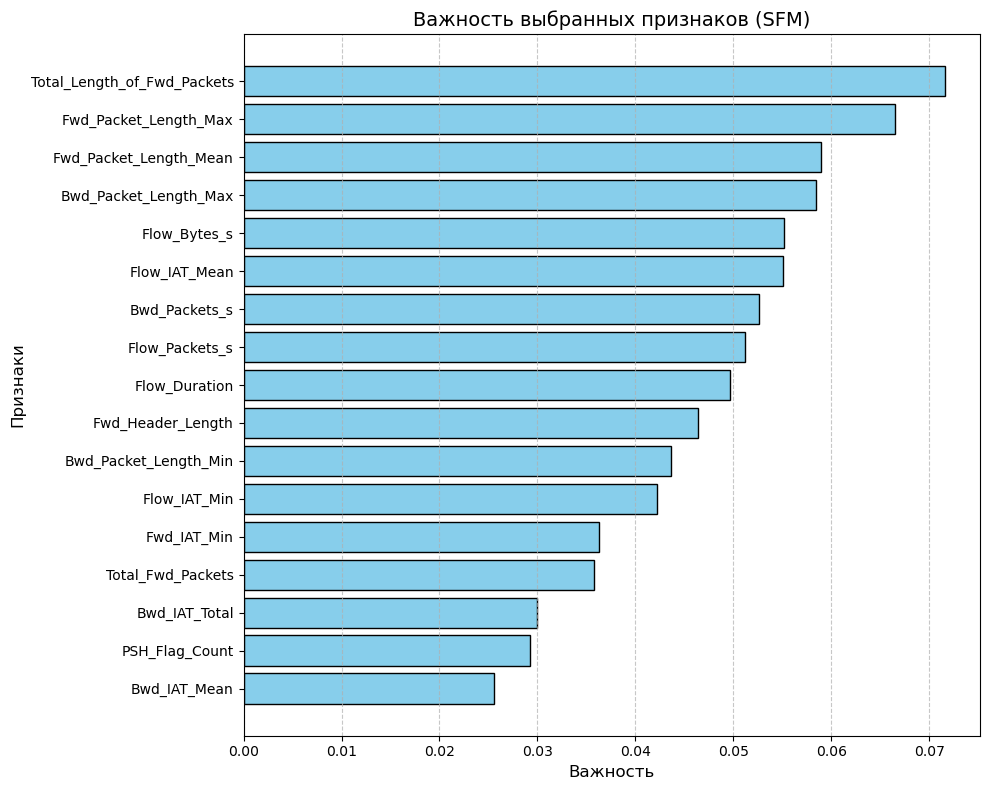

In [12]:
#Строим график с наиболее важными призанаками
#Отображение в графическом виде
import matplotlib.pyplot as plt

# Параметры графика
top_n = 17  # количество выводимых признаков

# Сортируем выбранные признаки по важности
sorted_indices_selected_sfm = np.argsort(selected_importances_sfm)[::-1]
top_indices = sorted_indices_selected_sfm[:top_n]

# Получаем названия и значения важностей
top_names = [x_train.columns[selected_indices_sfm[i]] for i in top_indices]
top_scores = selected_importances_sfm[top_indices]

# Визуализация
plt.figure(figsize=(10, 8))
plt.title('Важность выбранных признаков (SFM)', fontsize=14)
plt.barh(range(len(top_scores)), top_scores, color='skyblue', edgecolor='black')
plt.yticks(range(len(top_scores)), top_names)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.gca().invert_yaxis()  # Самый важный признак сверху
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sfm_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
""" Тестовые проверки данных """

#проверка размеров выборок
print("Train shape:", x_train_selected_sfm.shape)
print("Test shape:", x_test_selected_sfm.shape)

from collections import Counter

print("Классы в train:", sorted(Counter(y_train).items()))
print("Классы в test:", sorted(Counter(y_test_balanced).items()))

Train shape: (459617, 17)
Test shape: (4972, 17)
Классы в train: [(0, 100000), (1, 10000), (2, 89617), (3, 10000), (4, 100000), (5, 10000), (6, 10000), (7, 10000), (8, 100000), (9, 10000), (10, 10000)]
Классы в test: [(0, 452), (1, 452), (2, 452), (3, 452), (4, 452), (5, 452), (6, 452), (7, 452), (8, 452), (9, 452), (10, 452)]


#### Сохранение набора данных с отобранными признаками

In [15]:

# Преобразуем numpy.ndarray обратно в DataFrame
x_train_selected_df = pd.DataFrame(x_train_selected_sfm, columns=features_selected_sfm)
x_train_selected_df['Label'] = y_train.copy()

x_test_selected_df = pd.DataFrame(x_test_selected_sfm, columns=features_selected_sfm)
x_test_selected_df['Label'] = y_test.copy()

x_train_selected_df.to_csv('features_importances_train_data_selection.csv', index=False)
print("Файл тренировочной выборки успешно сохранен")

#Сохранение тестовой выборки с отобранными признаками в файл
x_test_selected_df.to_csv('features_importances_test_data_selection.csv', index=False)
print("Файл тестовой выборки, успешно сохранен")

print("\nЭтапы препроцессинга файлов успешно завершены!")

Файл тренировочной выборки успешно сохранен
Файл тестовой выборки, успешно сохранен

Этапы препроцессинга файлов успешно завершены!


### Шаг 3 - построение модели на отобранных признаках

In [17]:
#Обучаем новый лес на отобранных признаках
new_rfc = RandomForestClassifier(class_weight='balanced',random_state=42, oob_score=True, n_jobs=-1)

#Обучение
start_time = time.time()

new_rfc.fit(x_train_selected_sfm, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')


Время обучения модели: 7.35 секунд



In [18]:
#тест модли на тестовом наборе
y_pred = new_rfc.predict(x_test_selected_sfm)

#Оценка модели
print("Accuracy:", accuracy_score(y_test_balanced, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_balanced, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_balanced, y_pred))

Accuracy: 0.9766693483507642

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       452
           1       0.99      0.95      0.97       452
           2       1.00      1.00      1.00       452
           3       1.00      1.00      1.00       452
           4       0.98      1.00      0.99       452
           5       1.00      0.99      1.00       452
           6       1.00      1.00      1.00       452
           7       1.00      1.00      1.00       452
           8       1.00      1.00      1.00       452
           9       0.91      0.95      0.93       452
          10       0.99      0.89      0.94       452

    accuracy                           0.98      4972
   macro avg       0.98      0.98      0.98      4972
weighted avg       0.98      0.98      0.98      4972


Confusion Matrix:
[[438   3   0   0   6   0   0   0   0   5   0]
 [ 24 428   0   0   0   0   0   0   0   0   0]
 [  0   0 452   0   0

### Шаг 4 - Улучшение весов для классов модели RandomForest

In [20]:
from collections import Counter
counts = Counter(y_train)
total = sum(counts.values())
class_weights = {cls: round((total / count), 3) for cls, count in counts.items()}

print(f"Веса для классов: {class_weights}")

Веса для классов: {0: 4.596, 1: 45.962, 2: 5.129, 3: 45.962, 4: 4.596, 5: 45.962, 6: 45.962, 7: 45.962, 8: 4.596, 9: 45.962, 10: 45.962}


#### Построение модели RandomForest с настроенными весами

In [22]:
#построение модели с весами классов
new_rfc_2 = RandomForestClassifier(class_weight=class_weights,random_state=42, oob_score=True, n_jobs=-1)
#Обучение
start_time = time.time()

new_rfc_2.fit(x_train_selected_sfm, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')


Время обучения модели: 7.37 секунд



In [23]:
#тест модли на тестовом наборе
y_pred = new_rfc_2.predict(x_test_selected_sfm)

#Оценка модели
print("Accuracy:", accuracy_score(y_test_balanced, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_balanced, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_balanced, y_pred))

Accuracy: 0.9764682220434433

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       452
           1       0.99      0.95      0.97       452
           2       1.00      1.00      1.00       452
           3       1.00      0.99      1.00       452
           4       0.99      1.00      0.99       452
           5       1.00      0.99      1.00       452
           6       1.00      1.00      1.00       452
           7       1.00      1.00      1.00       452
           8       1.00      1.00      1.00       452
           9       0.91      0.95      0.93       452
          10       0.99      0.89      0.94       452

    accuracy                           0.98      4972
   macro avg       0.98      0.98      0.98      4972
weighted avg       0.98      0.98      0.98      4972


Confusion Matrix:
[[438   3   0   1   5   0   0   0   0   5   0]
 [ 24 428   0   0   0   0   0   0   0   0   0]
 [  0   0 452   0   0

In [24]:
#Сохранение весов в файл
weights_df = pd.DataFrame(list(class_weights.items()), columns=['Class','Weight'])
weights_df.to_csv('class_weights.csv', index=False)

### Шаг 5 - Оптимизация гиперпараметров в 2 раунда

#### Раунд 1 - используем RandomizedSearchCV

In [27]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(par) for par in np.linspace(start=100, stop=1000, num=10)]
max_features = ['log2', 'sqrt']
max_depth = [int(par) for par in np.linspace(start=1, stop=15, num=15)]
min_samples_split = [int(par) for par in np.linspace(start=2, stop=50, num=10)]
min_samples_leaf = [int(par) for par in np.linspace(start=2, stop=50, num=10)]
bootstrap = [True, False]

H_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}


rfc_hp = RandomForestClassifier(random_state=1)
rfc_hp.get_params().keys()

func_rcv = RandomizedSearchCV(rfc_hp, H_params, n_iter=100, cv=3,
                        verbose=1, n_jobs=-1, random_state=1)

In [28]:
start_time = time.time()
func_rcv.fit(x_train_selected_sfm, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Время обучения модели: 4086.24 секунд



In [29]:
display(f'Лучшие параметры для модели на сонове RandomizedSearchCV: {func_rcv.best_params_}')

"Лучшие параметры для модели на сонове RandomizedSearchCV: {'n_estimators': 300, 'min_samples_split': 39, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': False}"

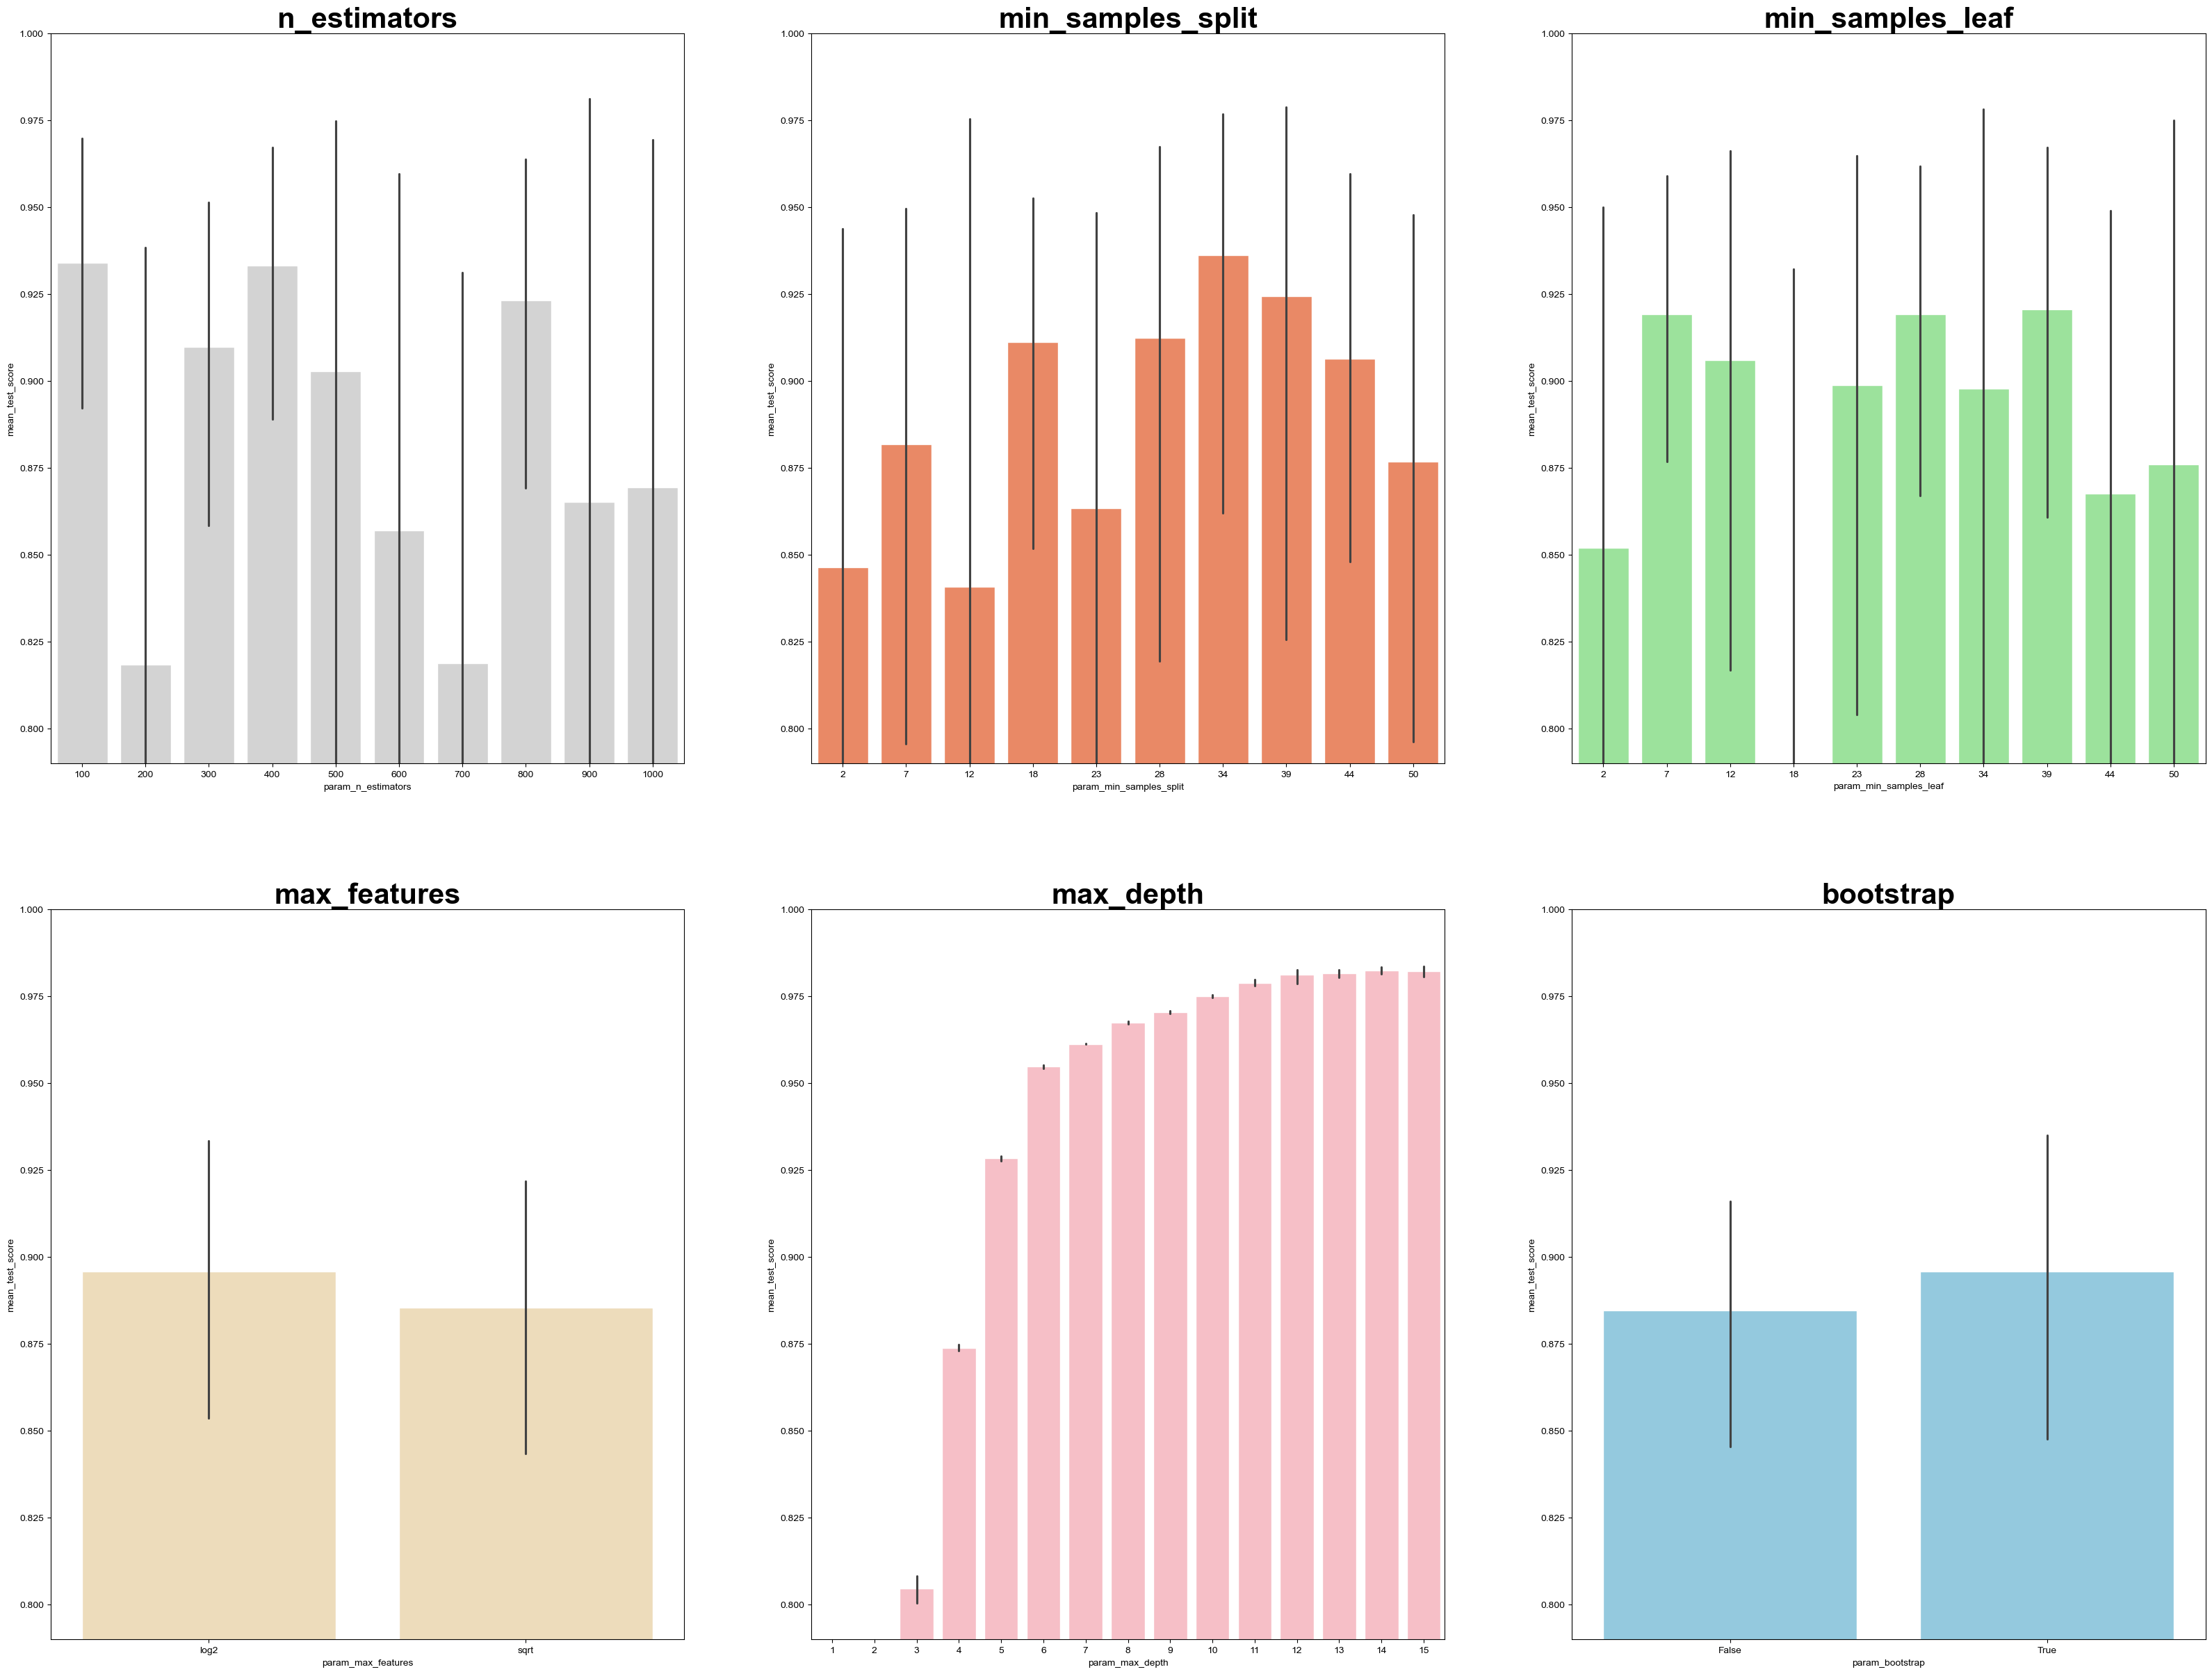

In [30]:
import seaborn as sns

#преобразовываем в датасет, для построения графика на основе значений
rcv_df = pd.DataFrame(func_rcv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
cv_df = rcv_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

#Создаем графики, чтобы понять какие значения подходят лучше всего в среднем
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(40,30)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rcv_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.79,1])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rcv_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.79,1])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rcv_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.79,1])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rcv_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.79,1])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rcv_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.79,1])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rcv_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.79,1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

#### Раунд 2 - используем GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

n_estimators = [300]
max_features = ['log2']
max_depth = [15]
min_samples_split = [39]
min_samples_leaf = [2]
bootstrap = [False]

H_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

gscv = GridSearchCV(rfc_hp, H_params, cv = 3, verbose = 1, n_jobs=-1)

In [33]:
start_time = time.time()
gscv.fit(x_train_selected_sfm, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Время обучения модели: 332.34 секунд



In [34]:
best_rfc = gscv.best_estimator_
display(f"Best params: {gscv.best_params_}")
display(f"Best estimator: {gscv.best_estimator_}")

"Best params: {'bootstrap': False, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 39, 'n_estimators': 300}"

"Best estimator: RandomForestClassifier(bootstrap=False, max_depth=15, max_features='log2',\n                       min_samples_leaf=2, min_samples_split=39,\n                       n_estimators=300, random_state=1)"

### Шаг 6 - Построение финальной модели с оптимизированными параметрами

In [36]:
rfс_hp_opt = RandomForestClassifier(
    n_estimators=800,
    max_depth=13,
    max_features='log2',
    min_samples_leaf=7,
    min_samples_split=34,
    random_state=1,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1
)

start_time = time.time()
rfс_hp_opt.fit(x_train_selected_sfm, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

y_pred = rfс_hp_opt.predict(x_test_selected_sfm)


Время обучения модели: 50.16 секунд



In [37]:
#Оценка модели
print("Accuracy:", accuracy_score(y_test_balanced, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_balanced, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_balanced, y_pred))

Accuracy: 0.9384553499597748

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       452
           1       0.99      0.65      0.79       452
           2       1.00      1.00      1.00       452
           3       1.00      0.99      1.00       452
           4       0.98      1.00      0.99       452
           5       1.00      0.99      1.00       452
           6       1.00      1.00      1.00       452
           7       1.00      1.00      1.00       452
           8       1.00      1.00      1.00       452
           9       0.93      0.83      0.88       452
          10       0.95      0.88      0.91       452

    accuracy                           0.94      4972
   macro avg       0.95      0.94      0.94      4972
weighted avg       0.95      0.94      0.94      4972


Confusion Matrix:
[[437   3   0   0   9   0   0   0   0   1   2]
 [156 296   0   0   0   0   0   0   0   0   0]
 [  0   0 452   0   0

In [38]:
print(f"OOB SCORE: {rfc.oob_score_}")

OOB SCORE: 0.9866976199748921


In [39]:
from sklearn.metrics import f1_score
# Посчитай F1-score
y_pred_oob = rfс_hp_opt.predict(x_train_selected_sfm)
f1 = f1_score(y_train, y_pred_oob, average='macro')
print("F1-macro:", f1)

F1-macro: 0.9760659601236451


### Шаг 7 - Сохранение моделей

In [41]:
import pickle

#Модель с настройками по умолчанию
with open('model_rfc_default.pkl', 'wb') as file:
    pickle.dump(rfc, file)

with open('model_rfc_optimized.pkl', 'wb') as file:
    pickle.dump(rfс_hp_opt, file)
    
print('Модель успешно сохранена в файл')

Модель успешно сохранена в файл
